In [3]:
import pandas as pd
import numpy as np
import sys, os
import seaborn as sns

from matplotlib import pyplot as plt
sys.path.insert(1, os.path.join(sys.path[0], '../../'))  # for importing local packages from src
sys.path.insert(1, os.path.join(sys.path[0], '../'))  # for importing model config

%reload_ext autoreload
%autoreload 2 

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{gensymb} \usepackage{siunitx}'
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 12

## Loading predictions

In [4]:
cn_pred = pd.read_csv('results_cnwheat_input_phys_predictions.csv', index_col=0)
hs_pred = pd.read_csv('results_hydroshoot_input_phys_predictions.csv', index_col=0)

In [5]:
hs_pred.head()

,input_Rg__true,input_Rg__state_Tlc,input_Rg__state_E,input_Rg__state_gs,output_Rg__true,output_Rg__state_Tlc,output_Rg__state_E,output_Rg__state_gs,output_An__true,output_An__state_Tlc,output_An__state_E,output_An__state_gs
0,-1.257627,-0.750853,-0.893200,-0.844656,-1.352480,-0.641399,-0.868592,-0.841067,-1.623972,-0.398986,-0.820100,-0.932815
1,-0.797091,-0.382883,-0.502288,-0.094382,-0.803670,-0.260185,-0.454168,-0.058702,0.133483,0.158753,-0.318825,0.074812
2,-0.189663,0.177390,-0.236109,0.018481,0.188815,0.481573,-0.138565,0.112869,0.739803,1.038819,-0.336222,0.217998
3,0.376191,1.100382,1.077729,0.909306,0.937627,1.357517,1.226575,0.927654,0.972980,1.092478,0.728658,0.851560
4,0.877199,1.364241,1.352049,1.057987,1.222997,1.477510,1.560373,1.203853,0.875595,0.936855,0.915340,0.680559


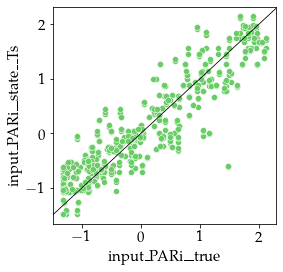

In [39]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes


with plt.style.context('seaborn-muted'):
  colors = sns.color_palette()
  plt.figure(figsize=(4,4))
  ax = sns.scatterplot(data=cn_pred, x='input_PARi__true', y='input_PARi__state__Ts', color=colors[1])
  # ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='black', linestyle='--', linewidth=1)
  add_identity(ax, color='black', linestyle='solid', linewidth=0.8)
  plt.show()

In [92]:

from sklearn.metrics import mean_squared_error

def nmse(y_true, y_pred, epsilon=1e-12):
    score = mean_squared_error(y_true, y_pred) / (y_true.var() + epsilon)
    return score

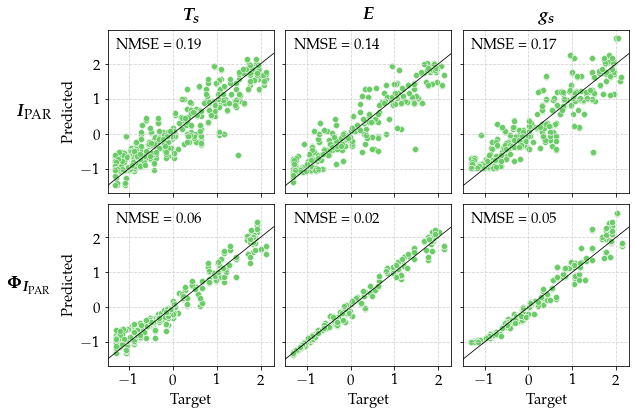

In [99]:
targets = 'input_PARi', 'output__custom__PARa'
reservoirs = 'state__Ts', 'state__Tr', 'state__gs'

target_symbols = {
  'input_PARi': r'$I_{\text{PAR}}$',
  'output__custom__PARa': r'$\Phi_{I_{\text{PAR}}}$',
}
target_symbols = {k: f'$\\boldsymbol{{{v[1:-1]}}}$' for k, v in target_symbols.items()}

reservoir_symbols = {
  'state__Ts': r"$T_s$",
  'state__Tr': r"$E$",
  'state__gs': r"$g_s$",
}
reservoir_symbols = {k: f'$\\boldsymbol{{{v[1:-1]}}}$' for k, v in reservoir_symbols.items()}



with plt.style.context('seaborn-muted'):
  fig, axs = plt.subplots(2, 3, figsize=(9, 6), sharey=True, sharex=True)
  colors = sns.color_palette()

  for row, axs_row, target in zip([0, 1], axs, targets):
    for col, ax, reservoir in zip([0, 1, 2], axs_row, reservoirs):
      # Data
      score = nmse(cn_pred[f'{target}__true'], cn_pred[f'{target}__{reservoir}'])
      sns.scatterplot(data=cn_pred, x=f'{target}__true', y=f'{target}__{reservoir}', color=colors[1], ax=ax)
      
      # Axes
      add_identity(ax, color='black', linestyle='solid', linewidth=0.8)
      ax.set_xticks([-1, 0, 1, 2])
      ax.grid(axis='both', color='lightgrey', linestyle='dashed')

      
      # Labeling
      ax.set_xlabel('Target')
      ax.set_ylabel('Predicted')
      if col == 0:
        ax.annotate(target_symbols[target], (-0.35, 0.5), xycoords='axes fraction', va='center', ha='right', fontsize=18)
      if row == 0:
        ax.annotate(reservoir_symbols[reservoir], (0.5, 1.07), xycoords='axes fraction', ha='center', fontsize=18)
      ax.annotate(f'NMSE = {score:.2f}', (0.05, 0.95), xycoords='axes fraction', va='top')

  plt.tight_layout()
  plt.subplots_adjust(wspace=0.07, hspace=0.07)  
  plt.savefig('regression_res_accuracy_cnwheat.png', dpi=200, facecolor='white', bbox_inches='tight')

  